In [44]:
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt

from dslab_virgo_tsi.visualizer import Visualizer
from dslab_virgo_tsi.base import Result, BaseSignals, OutResult, FinalResult
from dslab_virgo_tsi.constants import Constants as Const
from dslab_virgo_tsi.data_utils import load_data, normalize, unnormalize

In [45]:
visualizer = Visualizer()
visualizer.set_figsize()

In [91]:
with open("./results/SMOOTH_MONOTONIC_modeling_result.pkl", "rb") as handle:
    result: Result = pickle.load(handle)
        
base_sig: BaseSignals = result.base_signals
out_res: OutResult = result.out
final_res: FinalResult = result.final

other_res = load_data(Const.DATA_DIR, Const.VIRGO_TSI_FILE, "virgo_tsi")
other_res[Const.PMO6V_OLD] = other_res[Const.PMO6V_OLD].interpolate("nearest")
other_res = other_res[[Const.T, Const.PMO6V_OLD]].dropna()

other_tsi = other_res[Const.PMO6V_OLD].values
other_t = other_res[Const.T].values
other_triplet = (other_t, other_tsi, f"{Const.PMO6V_OLD}_corrected")
other_fourplet = (other_t, other_tsi, f"{Const.PMO6V_OLD}_corrected", False)

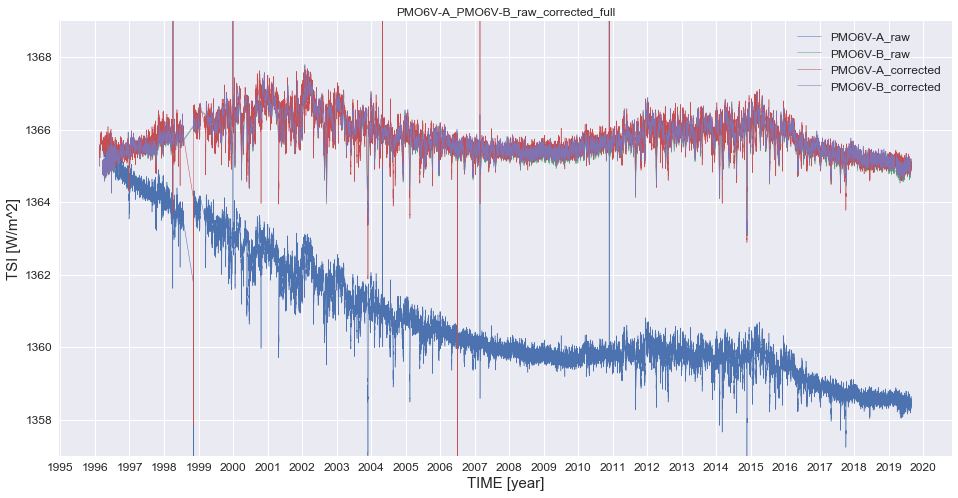

In [84]:
visualizer.plot_signals(
[
    (base_sig.t_a_nn, base_sig.a_nn, f"{Const.A}_raw", False),
    (base_sig.t_b_nn, base_sig.b_nn, f"{Const.B}_raw", False),
    (base_sig.t_a_nn, final_res.a_nn_corrected, f"{Const.A}_corrected", False),
    (base_sig.t_b_nn, final_res.b_nn_corrected, f"{Const.B}_corrected", False),
],
None, f"{Const.A}_{Const.B}_raw_corrected_full", x_ticker=1, y_lim=[1357, 1369],
legend="upper right", x_label=Const.YEAR_UNIT, y_label=Const.TSI_UNIT, max_points=1e5)

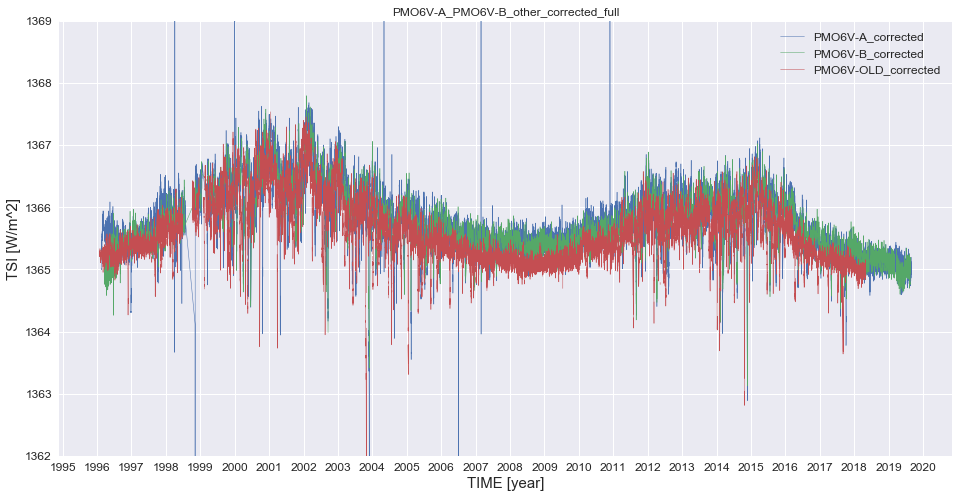

In [5]:
visualizer.plot_signals(
[
    (base_sig.t_a_nn, final_res.a_nn_corrected, f"{Const.A}_corrected", False),
    (base_sig.t_b_nn, final_res.b_nn_corrected, f"{Const.B}_corrected", False),
    other_fourplet
],
None, f"{Const.A}_{Const.B}_other_corrected_full", x_ticker=1, y_lim=[1362, 1369],
legend="upper right", x_label=Const.YEAR_UNIT, y_label=Const.TSI_UNIT)

t (5000,) [200.         200.40008002] [2199.59991998 2200.        ] 0.4000800160031872 0.40008001600321563
tau 0.40008001600320064
1500
t (5000,) [1250.         1250.40008002] [3249.59991998 3250.        ] 0.40008001600313037 0.40008001600335774
tau 0.40008001600320064
1500
t (5000,) [2000.         2000.40008002] [3999.59991998 4000.        ] 0.40008001600313037 0.40008001600335774
tau 0.40008001600320064
1500
t (5000,) [4000.         4000.40008002] [5999.59991998 6000.        ] 0.40008001600335774 0.400080016002903
tau 0.40008001600320064
1500


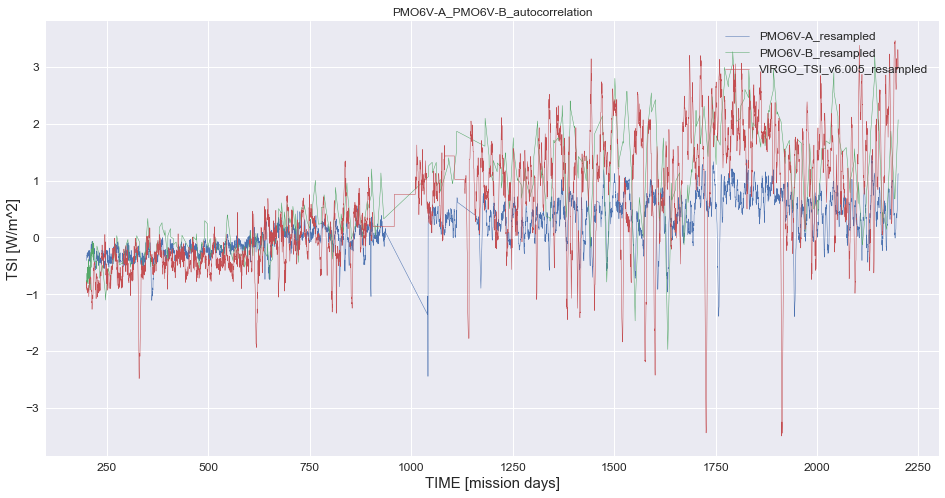

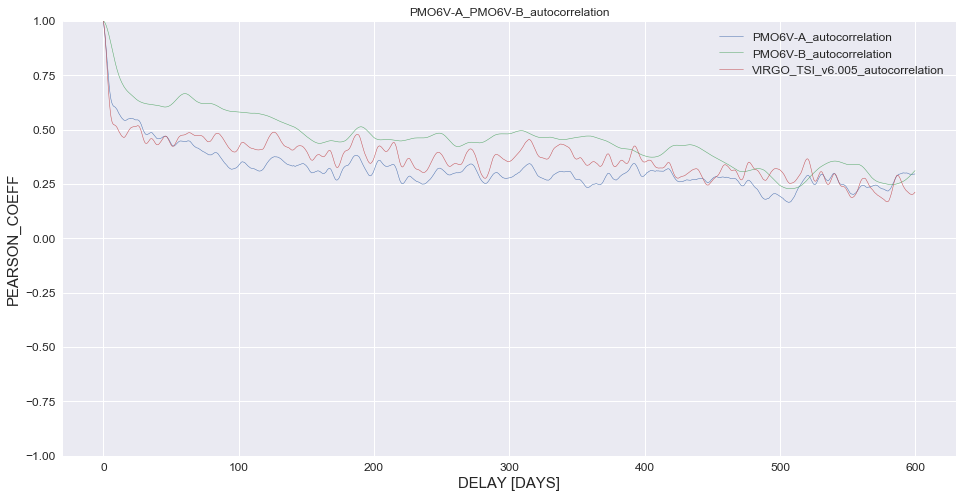

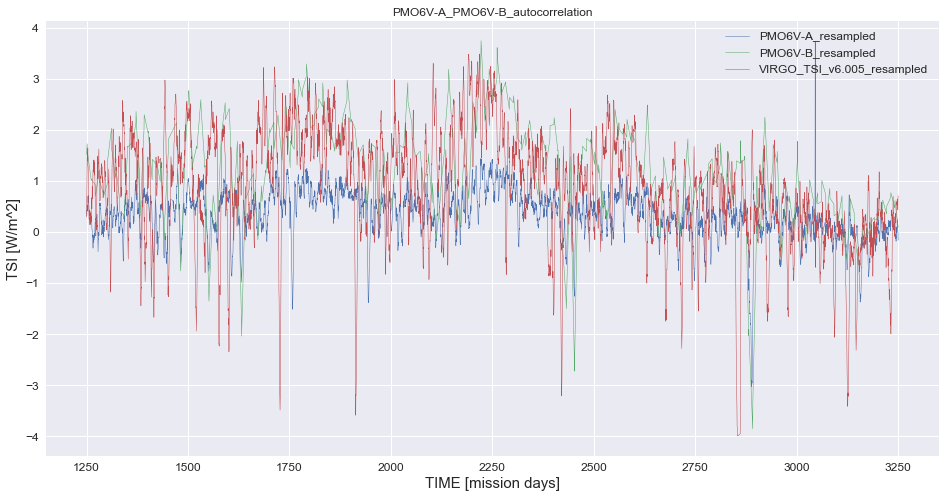

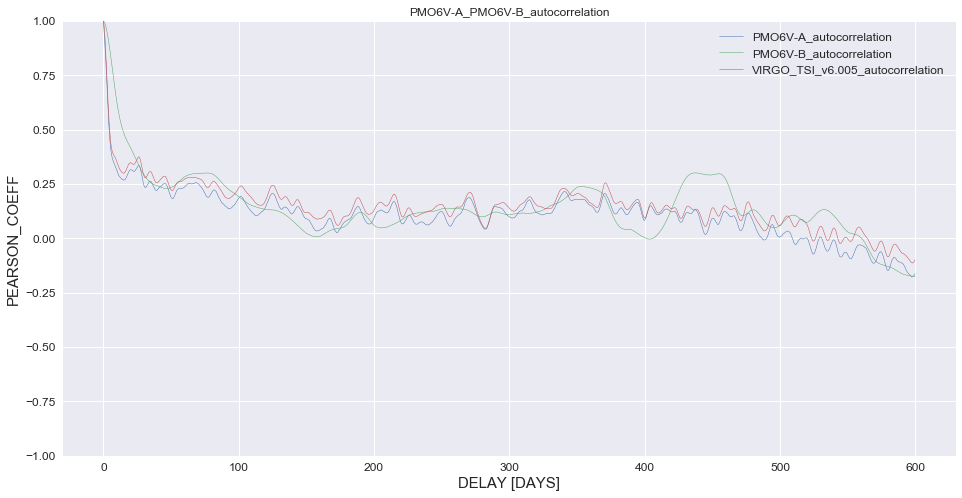

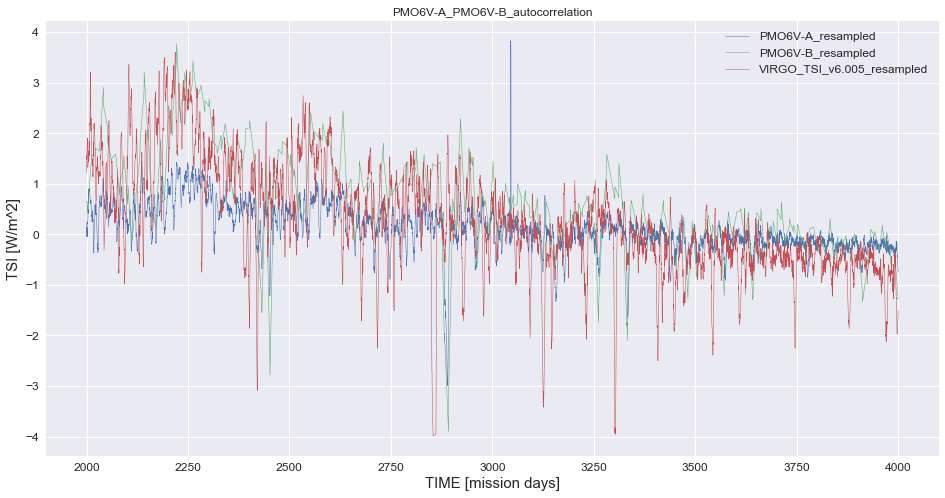

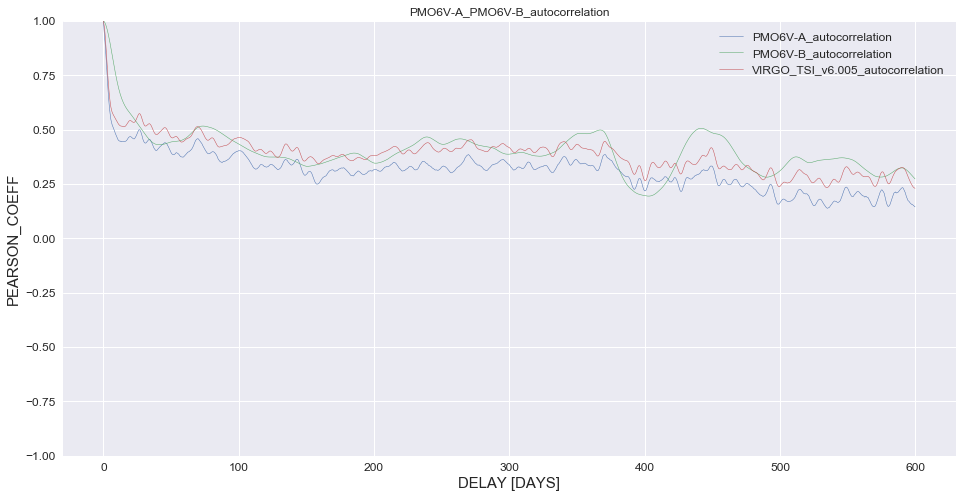

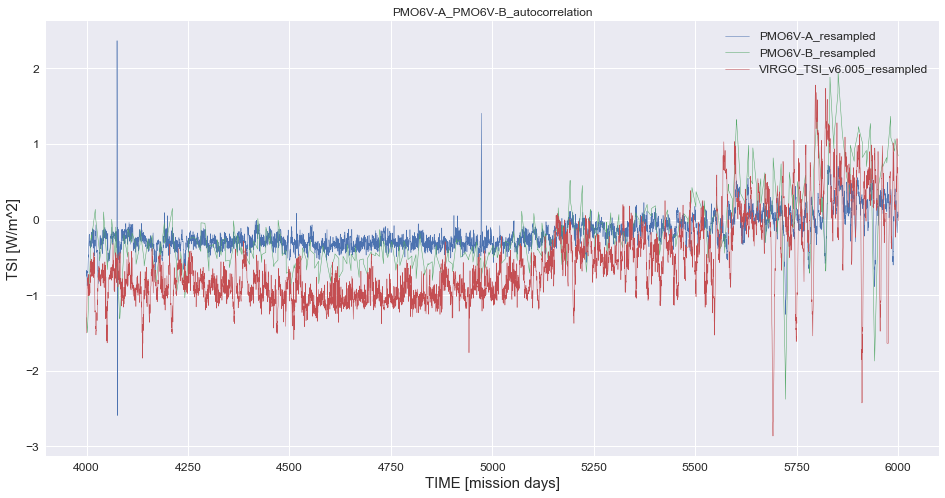

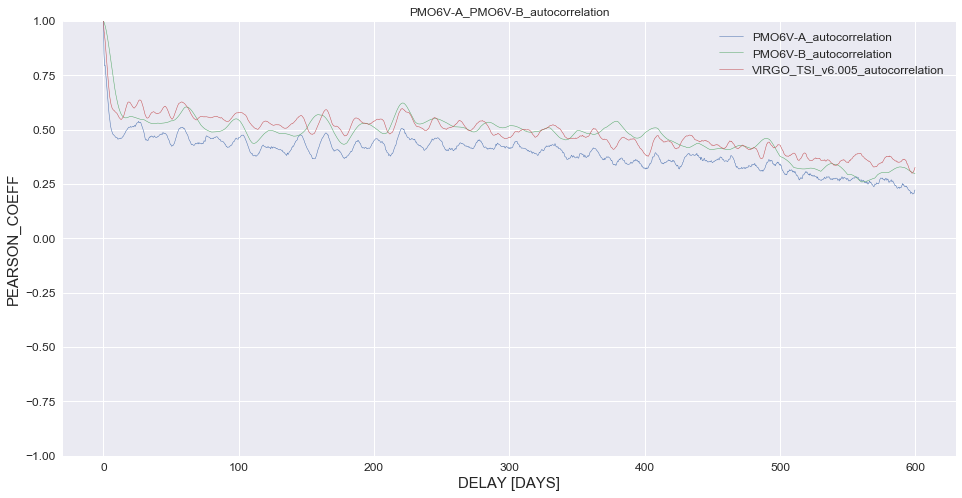

In [105]:
from scipy import interpolate
from scipy.optimize import curve_fit

t_min = np.max([other_t[0], base_sig.t_a_nn[0], base_sig.t_b_nn[0]])
t_max = np.min([other_t[-1], base_sig.t_a_nn[-1], base_sig.t_b_nn[-1]])

delay_window = 600
resampling_window = 2000
n_resampling_points = 5000

for t_min in [200, 1250, 2000, 4000, 6000, 8000]:
    t = np.linspace(t_min, t_min + resampling_window, n_resampling_points)
    tau = (t.max() - t.min())/(n_resampling_points-1)

    print("t", t.shape, t[:2], t[-2:], t[1] - t[0], t[2] - t[1])
    print("tau", tau)

    t_a, a = base_sig.t_a_nn, final_res.a_nn_corrected
    t_b, b = base_sig.t_b_nn, final_res.b_nn_corrected
    t_o, o = other_t, other_tsi

    if True:
        a = normalize(a, np.mean(a), np.std(a))
        b = normalize(b, np.mean(b), np.std(b))
        o = normalize(o, np.mean(o), np.std(o))

    if True:
        c_dev = 4
        clip_indices_a = np.multiply(np.greater_equal(a, -c_dev), np.less_equal(a, c_dev)).astype(np.bool).flatten()
        clip_indices_b = np.multiply(np.greater_equal(b, -c_dev), np.less_equal(b, c_dev)).astype(np.bool).flatten()
        clip_indices_o = np.multiply(np.greater_equal(o, -c_dev), np.less_equal(o, c_dev)).astype(np.bool).flatten()
        t_a, a = t_a[clip_indices_a], a[clip_indices_a]
        t_b, b = t_b[clip_indices_b], b[clip_indices_b]
        t_o, o = t_o[clip_indices_o], o[clip_indices_o]

    f_a = interpolate.interp1d(t_a, a)
    f_b = interpolate.interp1d(t_b, b)
    f_o = interpolate.interp1d(t_o, o)

    a, b, o = pd.Series(f_a(t)), pd.Series(f_b(t)), pd.Series(f_o(t))

    visualizer.plot_signals(
    [
        (t, a, f"{Const.A}_resampled", False),
        (t, b, f"{Const.B}_resampled", False),
        (t, o, f"VIRGO_TSI_v6.005_resampled", False),
    ],
    None, f"{Const.A}_{Const.B}_autocorrelation", 
    legend="upper right", x_label=Const.DAY_UNIT, y_label=Const.TSI_UNIT)

    n_lags = np.ceil(delay_window / tau).astype(int)
    print(n_lags)
    idx_delay = np.arange(0, n_lags, 1)
    t_delay = idx_delay * tau

    acorr_a, acorr_b, acorr_o = np.zeros(idx_delay.shape[0]), np.zeros(idx_delay.shape[0]), np.zeros(idx_delay.shape[0])
    acov_a, acov_b, acov_o = np.zeros(idx_delay.shape[0]), np.zeros(idx_delay.shape[0]), np.zeros(idx_delay.shape[0])

    for idx, lag in enumerate(idx_delay):
        acorr_a[idx] = a.autocorr(lag=lag)
        acorr_b[idx] = b.autocorr(lag=lag)
        acorr_o[idx] = o.autocorr(lag=lag)

    #     acov_a[idx] = a.corr(a.iloc[::-1].shift(lag))
    #     acov_b[idx] = b.corr(b.iloc[::-1].shift(lag))
    #     acov_o[idx] = o.corr(o.iloc[::-1].shift(lag))

    visualizer.plot_signals(
    [
        (t_delay, acorr_a, f"{Const.A}_autocorrelation", False),
        (t_delay, acorr_b, f"{Const.B}_autocorrelation", False),
        (t_delay, acorr_o, f"VIRGO_TSI_v6.005_autocorrelation", False),
    #     (t_delay, acov_a, f"{Const.A}_autocorrelation", False),
    #     (t_delay, acov_b, f"{Const.B}_autocorrelation", False),
    #     (t_delay, acov_o, f"VIRGO_TSI_v6.005_autocorrelation", False),
    ],
    None, f"{Const.A}_{Const.B}_autocorrelation",
    legend="upper right", x_label="DELAY [DAYS]", y_label="PEARSON_COEFF", y_lim=[-1, 1])

In [ ]:
def matern12(d, a0, a1):
    return a0 * np.exp(-d/a1)

def white(d, a0):
    return (d == 0) * a0

def constant(d, a0):
    return a0

def kernel(d, a0, a1, a2, a3):
    return white(d, a0) + matern12(d, a1, a2) + constant(d, a3)

popt_b, _ = curve_fit(kernel, lags, acorr_b, p0=[1.0, 1.0, 1.0, 1.0], maxfev=10000)
popt_o, _ = curve_fit(kernel, lags, acorr_o, p0=[1.0, 1.0, 1.0, 1.0], maxfev=10000)

print("b", popt_b)
print("o", popt_o)

k_b, k_o = kernel(lags, *popt_b), kernel(lags, *popt_o)

visualizer.plot_signals(
[
    (lags, acorr_a, f"{Const.A}_autocorrelation", True),
    (lags, acorr_b, f"{Const.B}_autocorrelation", True),
    (lags, acorr_o, f"VIRGO_TSI_v6.005_autocorrelation", True),
    (lags, k_o, "k_o", False), (lags, k_b, "k_b", False)
],
None, f"{Const.A}_{Const.B}_autocorrelation",
legend="upper right", x_label="LAG", y_label="PEARSON_COEFF")

In [ ]:
a, b, o = pd.Series(final_res.a_nn_corrected), pd.Series(final_res.b_nn_corrected), pd.Series(other_tsi)
a, b, o = a[::600], b[::2], o[::12]

n = 10000
acorr_a, acorr_b, acorr_o = np.zeros(n), np.zeros(n), np.zeros(n)

lags = np.arange(0, n, 1)
for idx, lag in enumerate(lags):
    acorr_a[idx] = a.autocorr(lag=lag)
    acorr_b[idx] = b.autocorr(lag=lag)
    acorr_o[idx] = o.autocorr(lag=lag)
    
visualizer.plot_signals(
[
    (lags, acorr_a, f"{Const.A}_autocorrelation", False),
    (lags, acorr_b, f"{Const.B}_autocorrelation", False),
    (lags, acorr_o, f"VIRGO_TSI_v6.005_autocorrelation", False),
],
None, f"{Const.A}_{Const.B}_autocorrelation",
legend="upper right", x_label="LAG", y_label="PEARSON_COEFF")